In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from xml.etree import ElementTree as ET
def collect_instance_data(xml_string):
    def _recurse(data, current_path, xml_element):
        current_path = current_path + '/' + xml_element.tag
        if len(xml_element) == 0:
            if current_path not in data:
                data[current_path] = []
            data[current_path].append(xml_element.text)
        else:    
            for child in xml_element:
                _recurse(data, current_path, child)
    data = {}
    xml_tree = ET.fromstring(xml_string)
    _recurse(data, '', xml_tree)
    return data

This function takes an XML document string and returns a dictionary that has tags (in a path like string) as keys and a list of texts in each occurance of that tag

In [3]:
def get_features(xml):
    data_as_dict = collect_instance_data(xml)
    df = pd.DataFrame(data_as_dict)
    df = df.melt(var_name='tag', value_name='item')
    return df

This function coverts the dictionary from collect_instane data to a DataFrame that can be passed to supervised learning models

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

def create_pipeline(model):            
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False)
    classifier = model if model != None else DecisionTreeClassifier()
    pipeline = make_pipeline(vectorizer, classifier)
    return pipeline
    

def compare_xmls(xml1, xml2, model):
    xml1_data = collect_instance_data(xml1)
    xml1_features = get_features(xml1)
    xml2_data = collect_instance_data(xml2)
    pipeline = create_pipeline(model)
    pipeline.fit(xml1_features['item'], xml1_features['tag'])

    output_shape =len(xml2_data.keys()), len(xml1_data.keys())
    outputs = pd.DataFrame(np.zeros(output_shape),
        index=xml2_data.keys(), columns=xml1_data.keys())
    
    for tag in xml2_data:
        predictions = pipeline.predict(xml2_data[tag])
        total = len(predictions)
        for p in predictions:
            outputs.loc[tag, p] += 1.0 / total
    return outputs

<h1>Testing With Countries Data</h1>

In [5]:
countries_xmls = []
for i in range(2):
    filename = 'data/countries_' + str(i + 1) + '.xml'
    with open(filename) as file:
        countries_xmls.append(file.read())

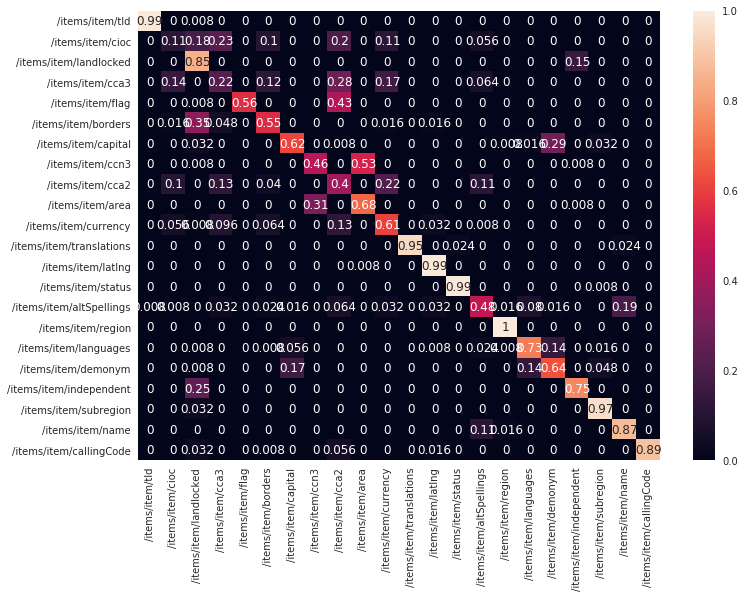

In [18]:
results = compare_xmls(countries_xmls[1], countries_xmls[0])
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(results, annot=True)

<h1>Countries XML with Naive Bayes</h1>

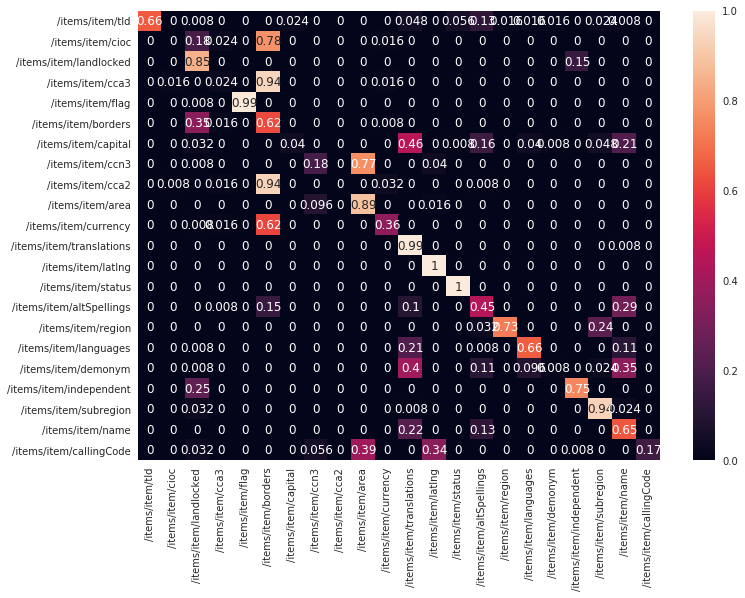

In [22]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
results = compare_xmls(countries_xmls[1], countries_xmls[0], model=model)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(results, annot=True)

<h1>Countries XML With LogisticRegression</h1>

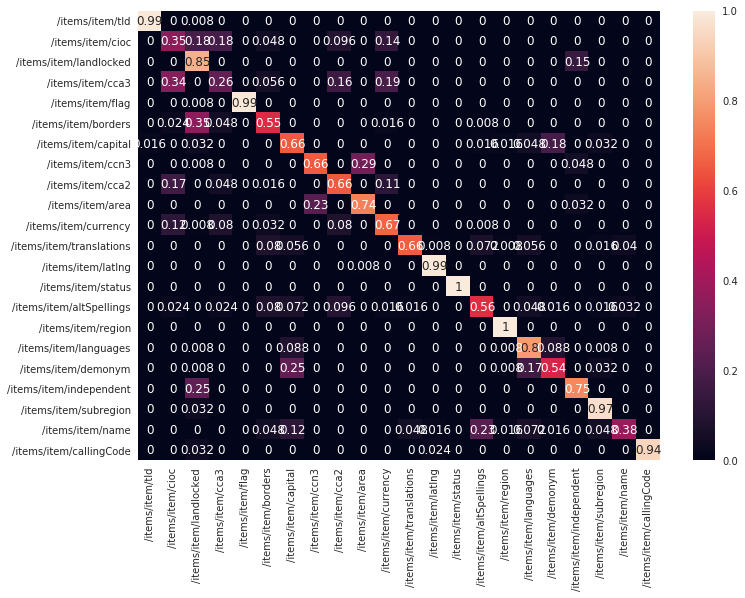

In [24]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
results = compare_xmls(countries_xmls[1], countries_xmls[0], model=model)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(results, annot=True)

# Titanic XML with DecisionTree

In [25]:
!ls data

countries_1.xml  seattle_1.xml	seattle_3.xml  seattle_5.xml  titanic_2.xml
countries_2.xml  seattle_2.xml	seattle_4.xml  titanic_1.xml


In [26]:
filenames = ['data/titanic_1.xml', 'data/titanic_2.xml']
xmls = []
for filename in filenames:
    with open(filename) as file:
        xmls.append(file.read())

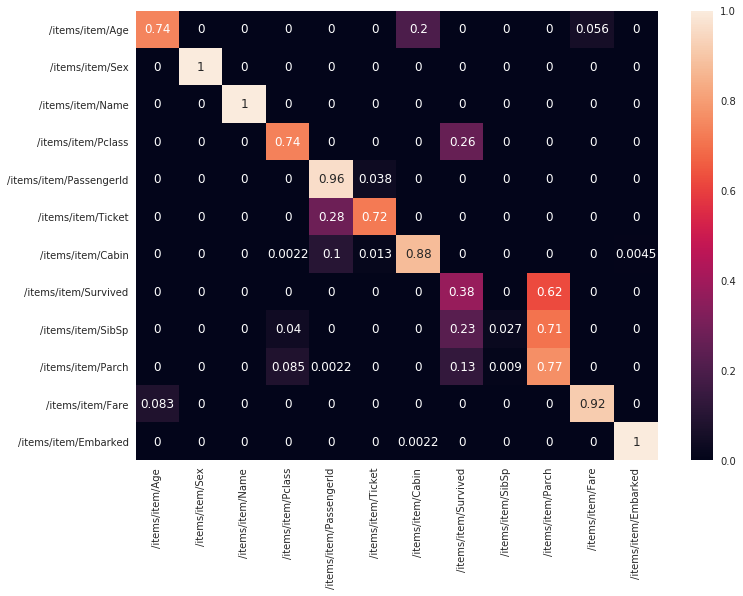

In [29]:
results = compare_xmls(xmls[0], xmls[1], model=None)
sns.heatmap(results, annot=True)

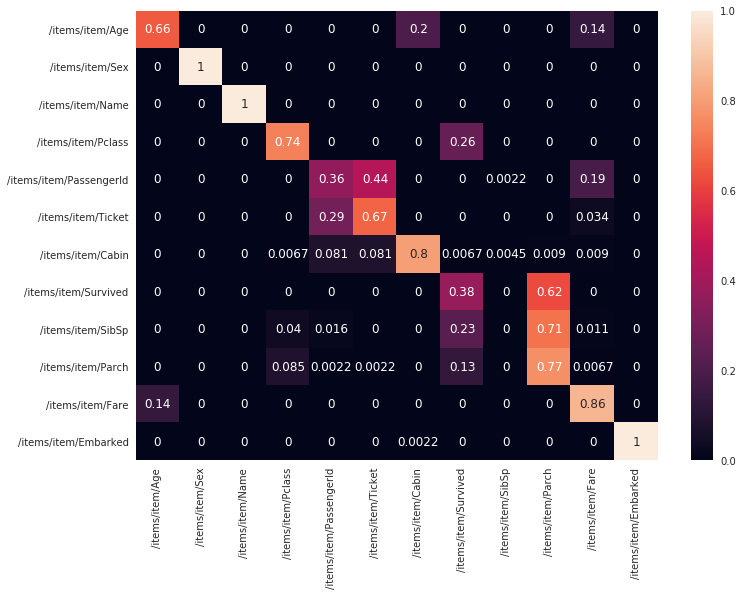

In [30]:
results = compare_xmls(xmls[0], xmls[1], model=MultinomialNB())
sns.heatmap(results, annot=True)